In [47]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
# Getting the data 1
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'
dataset_path = '../datasets/'
response = requests.get(url)
with open(f'{dataset_path}laptops.csv', 'wb') as file:
    for chunk in response.iter_content(chunk_size=1024):
        file.write(chunk)

In [24]:
# Getting the data 2
laptops = pd.read_csv(f'{dataset_path}laptops.csv')
laptops.columns = laptops.columns.str.lower().str.replace(' ', '_')

In [25]:
df = laptops[['ram', 'storage', 'screen', 'final_price']]

In [26]:
# Question 1
# There's one column with missing values. What is it?
missing_values = df.isnull().any()
print(missing_values)

ram            False
storage        False
screen          True
final_price    False
dtype: bool


In [27]:
# Question 2
# What's the median (50% percentile) for variable 'ram'?
median_value = laptops['ram'].median()
print(median_value)

16.0


In [28]:
# Prepare and split the dataset
# Shuffle the dataset (the filtered one you created above), use seed 42.
# Split your data in train/val/test sets, with 60%/20%/20% distribution.
# Use the same code as in the lectures
n = len(df)

n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test
print(n_train, n_val, n_test)

1296 432 432


In [29]:
idx = np.arange(n)
np.random.seed(42)
np.random.shuffle(idx)

df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

In [30]:
# Question 3
# We need to deal with missing values for the column from Q1.
# We have two options: fill it with 0 or with the mean of this variable.
# Try both options. For each, train a linear regression model without regularization using the code from the lessons.
# For computing the mean, use the training only!
# Use the validation dataset to evaluate the models and compare the RMSE of each option.
# Round the RMSE scores to 2 decimal digits using round(score, 2)
# Which option gives better RMSE?
# Options:
# 
# With 0
# With mean
# Both are equally good

In [31]:
base = ['ram', 'storage', 'screen']

In [35]:
def prepare_X(df):
    df_num = df[base]
    df_num = df_num.fillna(0)
    X = df_num.values
    return X

def prepare_X_with_Mean(df):
    df_num = df[base]
    df_num = df_num.fillna(df_num.mean())
    X = df_num.values
    return X

In [36]:
def train_linear_regression(X, y):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])
    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [15]:
X_train = prepare_X(df_train)
X_train_mean = prepare_X_with_Mean(df_train)

In [16]:
w0, w = train_linear_regression(X_train, y_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

In [17]:
y_pred = w0 + X_train.dot(w)
y_pred_mean = w0_mean + X_train_mean.dot(w_mean)

In [18]:
def rmse(y, y_p):
    se = (y - y_p) ** 2
    mse = se.mean()
    return np.sqrt(mse)

In [19]:
rmse(y_train, y_pred)

np.float64(602.3920520606714)

In [18]:
rmse(y_train, y_pred_mean)

np.float64(602.1844959403247)

<Axes: ylabel='Count'>

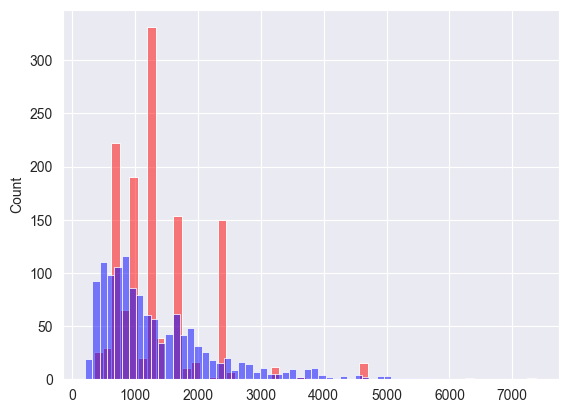

In [19]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_train, label='target', color='blue', alpha=0.5, bins=50)

<Axes: ylabel='Count'>

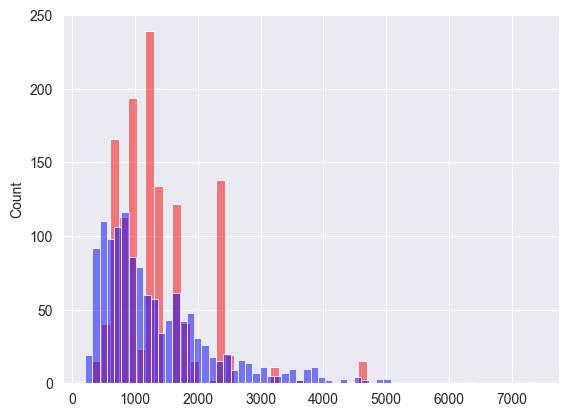

In [20]:
sns.histplot(y_pred_mean, color='red', alpha=0.5, bins=50)
sns.histplot(y_train, color='blue', alpha=0.5, bins=50)

In [21]:
# Train
X_train = prepare_X(df_train)
w0, w = train_linear_regression(X_train, y_train)

# Validate
X_val = prepare_X(df_val)
y_pred = w0 + X_val.dot(w)

# RMSE
score = rmse(y_val, y_pred)
round(score, 2)

np.float64(597.36)

In [22]:
# Train
X_train_mean = prepare_X_with_Mean(df_train)
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)

# Validate
X_val_mean = prepare_X_with_Mean(df_val)
y_pred_mean = w0_mean + X_val_mean.dot(w_mean)

# RMSE
score_mean = rmse(y_val, y_pred_mean)
round(score_mean, 2)

np.float64(600.26)

In [23]:
# Question 4
# Now let's train a regularized linear regression.
# For this question, fill the NAs with 0.
# Try different values of r from this list: [0, 0.01, 0.1, 1, 5, 10, 100].
# Use RMSE to evaluate the model on the validation dataset.
# Round the RMSE scores to 2 decimal digits.
# Which r gives the best RMSE?
# If there are multiple options, select the smallest r.
# Options:
# 
# 0
# 0.01
# 1
# 10
# 100

In [24]:
def train_linear_regression_reg(X, y, r):
    ones = np.ones(X.shape[0])
    X = np.column_stack([ones, X])

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(XTX.shape[0])

    XTX_inv = np.linalg.inv(XTX)
    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [25]:
for v in [0.0, 0.01, 0.1, 1, 5, 10, 100]:
    # Train
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression_reg(X_train, y_train, r=v)
    # Validate
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    # RMSE
    score = rmse(y_val, y_pred)
    print(v, w0, round(score, 2))

0.0 676.8954853007726 597.36
0.01 676.2736817208757 597.36
0.1 670.7284836317006 597.35
1 619.9030834110729 597.21
5 463.7771697143777 597.01
10 352.7971336768751 597.06
100 66.92071440181408 597.9


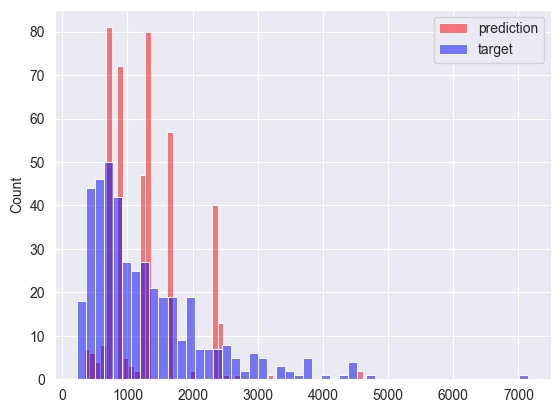

In [26]:
sns.histplot(y_pred, label='prediction', color='red', alpha=0.5, bins=50)
sns.histplot(y_val, label='target', color='blue', alpha=0.5, bins=50)
plt.legend()

In [27]:
# Question 5
# We used seed 42 for splitting the data. Let's find out how selecting the seed influences our score.
# Try different seed values: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9].
# For each seed, do the train/validation/test split with 60%/20%/20% distribution.
# Fill the missing values with 0 and train a model without regularization.
# For each seed, evaluate the model on the validation dataset and collect the RMSE scores.
# What's the standard deviation of all the scores? To compute the standard deviation, use np.std.
# Round the result to 3 decimal digits (round(std, 3))
# What's the value of std?
# 
# 19.176
# 29.176
# 39.176
# 49.176
# Note: Standard deviation shows how different the values are. If it's low, then all values are approximately the same. If it's high, the values are different. If standard deviation of scores is low, then our model is stable.

In [28]:
def prepare_with_seed(s):
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)
    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    return df_train, df_val, df_test

In [29]:
arr=[]

for s in [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]:
    df_train, df_val, df_test = prepare_with_seed(s)
    df_train = df_train.reset_index(drop=True)
    df_val = df_val.reset_index(drop=True)
    df_test = df_test.reset_index(drop=True)
    y_train = df_train.final_price.values
    y_val = df_val.final_price.values
    y_test = df_test.final_price.values
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']
    base = ['ram', 'storage', 'screen']
    # Train
    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)
    # Validate
    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)
    # RMSE
    score = rmse(y_val, y_pred)
    arr.append(score)
    print(s, w0, score)
    

0 547.5696230187814 565.4520868770982
1 594.419742800302 636.7985423056721
2 649.4685454772766 588.9558697907974
3 571.9459040115031 597.8148920012529
4 629.3882030647713 571.9627915111022
5 580.7647373332233 573.2383256618932
6 783.768368991014 647.3438328407256
7 376.4358600625769 550.4398184485927
8 572.88523611998 587.3335036169934
9 663.3792792611099 576.1017929433089


In [30]:
std = np.std(arr)
round(std, 3)

np.float64(29.176)

In [31]:
# Question 6
# Split the dataset like previously, use seed 9.
# Combine train and validation datasets.
# Fill the missing values with 0 and train a model with r=0.001.
# What's the RMSE on the test dataset?
# Options:
# 
# 598.60
# 608.60
# 618.60
# 628.60


In [32]:
df_train, df_val, df_test = prepare_with_seed(9)
df_full_train = pd.concat([df_train, df_val])
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.final_price.values
y_val = df_val.final_price.values
y_test = df_test.final_price.values

y_full_train = np.concatenate([y_train, y_val])

del df_train['final_price']
del df_val['final_price']
del df_test['final_price']
base = ['ram', 'storage', 'screen']


In [33]:
# Train
X_full_train = prepare_X(df_full_train)
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)
# Validate
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)
# RMSE
score = rmse(y_test, y_pred)

In [34]:
score

np.float64(608.6099822049554)